# Ordinary and Weighted Least-Squares of Linear Models

Author: Joris De Ridder

## Contents

- [Imports](#Imports)
- [Configuration](#Configuration)
- [Creating a synthetic dataset as an example](#Creating-a-synthetic-dataset-as-an-example)
- [Fitting the data with Ordinary Least-Squares](#Fitting-the-data-with-Ordinary-Least-Squares)
    - [Using the design matrix directly](#Using-the-design-matrix-directly)
    - [Using an R-style formula](#Using-an-R-style-formula)
    - [Calculating the summary() quantities manually](#Calculating-the-summary-quantities-manually)
    - [Diagnostic figures](#Diagnostic-figures)
- [Fitting the data with Weighted Least-Squares](#Fitting-the-data-with-Weighted-Least-Squares)
    - [Plotting the mean response and a confidence interval](#Plotting-the-mean-response-and-a-confidence-interval) 

## Imports

In [1]:
import numpy as np

In [2]:
import scipy as sp

In [3]:
import pandas as pd

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
from statsmodels.graphics.gofplots import qqplot

In [5]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

In [6]:
import seaborn as sns

In [7]:
import plotly.express as px
import plotly.graph_objects as go

**Relevant documentation:** 
    
[NumPy](https://numpy.org/doc/stable/)  -  [SciPy](https://docs.scipy.org/doc/scipy/reference/)  -  [Pandas](https://pandas.pydata.org/docs/)  -   [Statsmodels](https://www.statsmodels.org/stable/index.html)  -  [Matplotlib examples](https://matplotlib.org/stable/gallery/index.html) - [Seaborn](https://seaborn.pydata.org/)  - [Plotly](https://plotly.com/python/)

## Configuration

I find the default font sizes of the figures in matplotlib too small, so let's make them somewhat bigger:

In [8]:
plt.rc('font',   size=16)          # controls default text sizes
plt.rc('axes',   titlesize=18)     # fontsize of the axes title
plt.rc('axes',   labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=18)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=18)     # fontsize of the tick labels
plt.rc('legend', fontsize=18)      # legend fontsize
plt.rc('figure', titlesize=18)     # fontsize of the figure title

## Creating a synthetic dataset as an example

In [9]:
rng = np.random.default_rng(125)
N = 30                                                          # Number of observations
K = 3                                                           # Number of fit parameters
x = np.sort(rng.uniform(0, 20, N))
sigma = 0.1 + 0.03 * x                                          # measuring device is aging, uncertainties increase
y = 0.5 + 0.1 * x + np.sin(x) + rng.normal(0.0, sigma)

Note that I used a random number generator (rng) to generate random numbers. This is the more modern Python way, and will replace the older `np.random.normal()` functions. The number 125 is the random seed, which is not compulsary, but it allows to reproduce the exact same dataset when you run the notebook again.

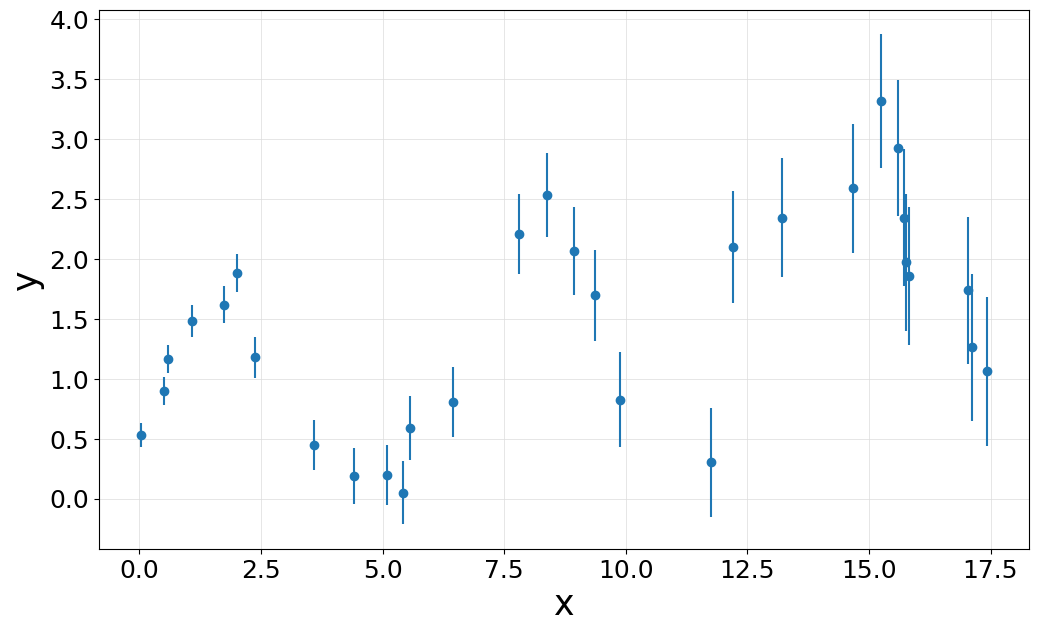

In [10]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.errorbar(x, y, yerr=sigma, fmt='o')
ax.set_xlabel('x', fontsize=25)
ax.set_ylabel('y', fontsize=25)
ax.set_facecolor('white')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

## Fitting the data with Ordinary Least-Squares

The model we will fit is

$$ y = \theta_0 + \theta_1 x  + \theta_2 \sin x + \varepsilon $$

Our first fit will be with Ordinary Least-Squares (OLS) which assumes that the uncertainties on all observations are the same. In our example this is clearly not the case, but it will illustrate the different results of OLS and WLS (weighted least-squars).

### Using the design matrix directly

In [11]:
X = sm.add_constant(np.column_stack([x, np.sin(x)]))

In [12]:
X[:5,:]            # Showing the first 5 rows

array([[1.        , 0.03991216, 0.03990156],
       [1.        , 0.51052561, 0.48863591],
       [1.        , 0.58942717, 0.55588495],
       [1.        , 1.0887273 , 0.88603759],
       [1.        , 1.73196929, 0.98703973]])

In [13]:
olsFit = sm.OLS(y, X).fit()

In [14]:
olsFit.summary(xname=['theta0', 'theta1', 'theta2'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     82.59
Date:                Thu, 23 Mar 2023   Prob (F-statistic):           3.12e-12
Time:                        17:34:41   Log-Likelihood:                -8.7240
No. Observations:                  30   AIC:                             23.45
Df Residuals:                      27   BIC:                             27.65
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
theta0         0.4256      0.118      3.593      0.001       0.183       0.669
theta1         0.1156      0.011     10.208      0.000       0.092       0.139
theta2         1.0521      0.098     10.745      0.000       0.851       1.253
==============================================================================
Omnibus:                        0.118   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.943   Jarque-Bera (JB):                0.143
Skew:                           0.118   Prob(JB):                        0.931
Kurtosis:                       2.757   Cond. No.                         21.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Using an R-style formula

Alternatively, instead of the design matrix, we can use an R-style formula to do the fit. This does require the data to be in a Pandas dataframe, so let's create this first.

In [15]:
df = pd.DataFrame({'y' : y, 'x': x})

In [16]:
df.head()

,y,x
0,0.528540,0.039912
1,0.897439,0.510526
2,1.165002,0.589427
3,1.484723,1.088727
4,1.617855,1.731969


In [17]:
olsFit = sm.OLS.from_formula(formula='y ~ x + I(np.sin(x))', data=df).fit()

In [18]:
olsFit.summary(xname=['theta0', 'theta1', 'theta2'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     82.59
Date:                Thu, 23 Mar 2023   Prob (F-statistic):           3.12e-12
Time:                        17:34:44   Log-Likelihood:                -8.7240
No. Observations:                  30   AIC:                             23.45
Df Residuals:                      27   BIC:                             27.65
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
theta0         0.4256      0.118      3.593      0.001       0.183       0.669
theta1         0.1156      0.011     10.208      0.000       0.092       0.139
theta2         1.0521      0.098     10.745      0.000       0.851       1.253
==============================================================================
Omnibus:                        0.118   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.943   Jarque-Bera (JB):                0.143
Skew:                           0.118   Prob(JB):                        0.931
Kurtosis:                       2.757   Cond. No.                         21.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Pandas dataframes have the additional advantage that you can easily compute summary statistics:

In [19]:
df.describe()

,y,x
count,30.000000,30.000000
mean,1.472020,8.826684
std,0.878176,5.928129
min,0.049061,0.039912
25%,0.811112,3.795498
50%,1.551289,8.655404
75%,2.089323,15.103409
max,3.317220,17.421890


In [20]:
df.corr()         # Correlation

,y,x
y,1.000000,0.508624
x,0.508624,1.000000


### Calculating the summary quantities manually

OLS assumes a constant variance for each observation. If you don't know it, you can estimate it from the residuals:

$$ s^2 = \frac{1}{N-K} \sum_{n=1}^N (y_n - \hat{y}_n)^2 $$

In [21]:
s2 = np.sum(olsFit.resid**2) / (N-K)
print("Estimated variance of the noise: ", s2)

Estimated variance of the noise:  0.11637735309300207


The covariance matrix 
$${\rm Cov}[\hat{\theta}] = s^2 (X' X)^{-1}$$

In [22]:
print("Covariance matrix of the fit parameters:\n", olsFit.cov_params())
print("\n")
covMatrix = s2 * np.linalg.inv(X.T @ X)
print("Calculated manually:\n", covMatrix)

Covariance matrix of the fit parameters:
               Intercept         x  I(np.sin(x))
Intercept      0.014035 -0.001141     -0.003475
x             -0.001141  0.000128      0.000367
I(np.sin(x))  -0.003475  0.000367      0.009587


Calculated manually:
 [[ 0.01403542 -0.00114085 -0.00347481]
 [-0.00114085  0.00012822  0.0003667 ]
 [-0.00347481  0.0003667   0.00958696]]


The correlation matrix:

In [23]:
corrMatrix = olsFit.cov_params().corr()

<Axes: >

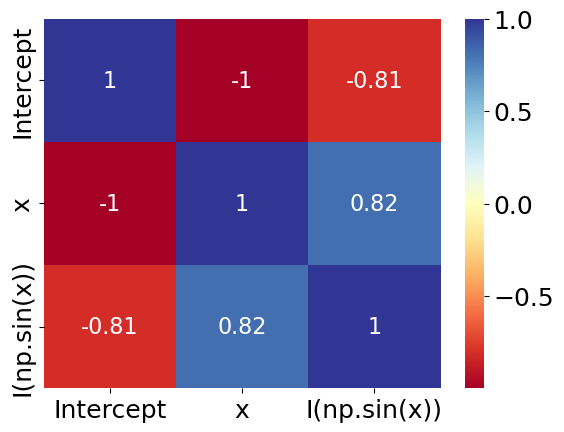

In [24]:
sns.heatmap(corrMatrix, cmap='RdYlBu', annot=True)

The standard errors of the fit parameters:

In [25]:
print("Standard errors:\n", olsFit.bse)
print("\n")
print("Calculated manually: ", np.sqrt(np.diagonal(olsFit.cov_params())))

Standard errors:
 Intercept       0.118471
x               0.011323
I(np.sin(x))    0.097913
dtype: float64


Calculated manually:  [0.11847118 0.01132336 0.09791303]


The coefficient of determination:
    $$ R^2 = 1 - \frac{\sum_{n=1}^N (y_n - \hat{y}_n)^2}{\sum_{n=1}^N (y_n - \bar{y})^2}  $$

In [26]:
print("Coefficient of determination: ", olsFit.rsquared)
print("Calculated manually: ", 1 - np.sum(np.square(olsFit.resid)) / np.sum(np.square(y-np.mean(y))))

Coefficient of determination:  0.859501663048675
Calculated manually:  0.859501663048675


The t-values:
    $$ t = \frac{\theta}{\sigma_{\theta}} $$

In [27]:
print("t-values:\n", olsFit.tvalues)
print("\n")
print("Calculated manually:\n", olsFit.params / olsFit.bse)

t-values:
 Intercept        3.592705
x               10.208012
I(np.sin(x))    10.745145
dtype: float64


Calculated manually:
 Intercept        3.592705
x               10.208012
I(np.sin(x))    10.745145
dtype: float64


The confidence intervals of the fit parameters:
    $$ \hat{\theta} \pm t^{(\alpha/2)}_{N-K} \ \hat{\sigma}_{\hat{\theta}} $$

In [28]:
print("95% confidence intervals:\n", olsFit.conf_int(0.05))
print("\n")

print("Calculated manually:")
Tdistrib = sp.stats.t(N-K)
quantile = Tdistrib.ppf(1-0.05/2)
for theta, sigma_theta in zip(olsFit.params, olsFit.bse):
    print(theta - quantile * sigma_theta, theta + quantile * sigma_theta)

95% confidence intervals:
                      0         1
Intercept     0.182549  0.668715
x             0.092355  0.138823
I(np.sin(x))  0.851189  1.252991


Calculated manually:
0.1825491822006092 0.6687147613947043
0.09235537641213103 0.13882260524742338
0.8511887124627842 1.2529905911675374


### Diagnostic figures

#### Pair plots

To verify multicollinarity between different regressors

In [29]:
regressors = pd.DataFrame({'x1': x, 'x2': np.sin(x)})

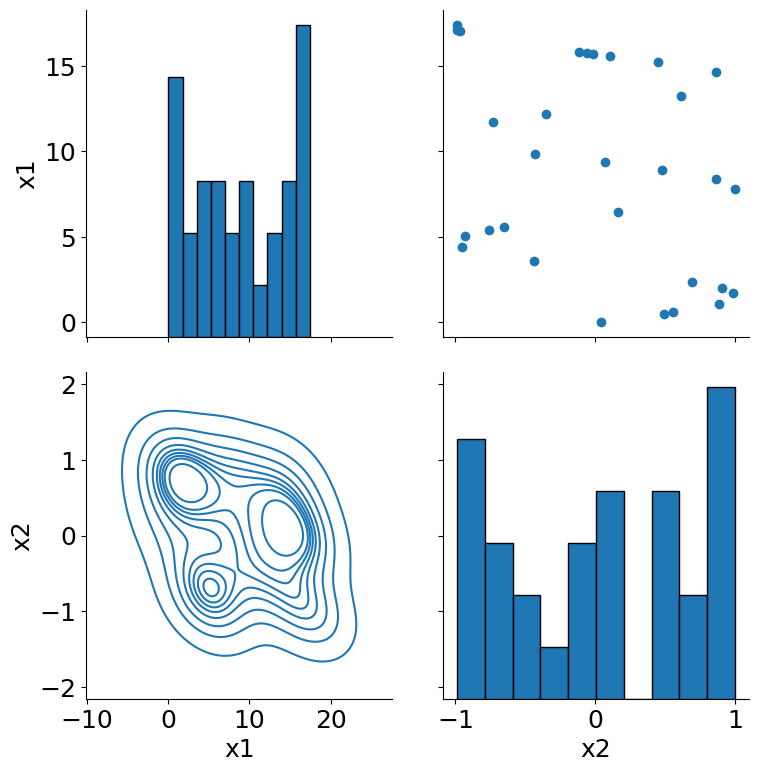

In [30]:
grid = sns.PairGrid(data=regressors, vars = ['x1', 'x2'], height = 4)
grid = grid.map_upper(plt.scatter)
grid = grid.map_diag(plt.hist, bins = 10, edgecolor = 'k')
grid = grid.map_lower(sns.kdeplot)

There seems to be no significant correlation between the two non-constant regressors that make up our design matrix $X$.

#### Residual plots

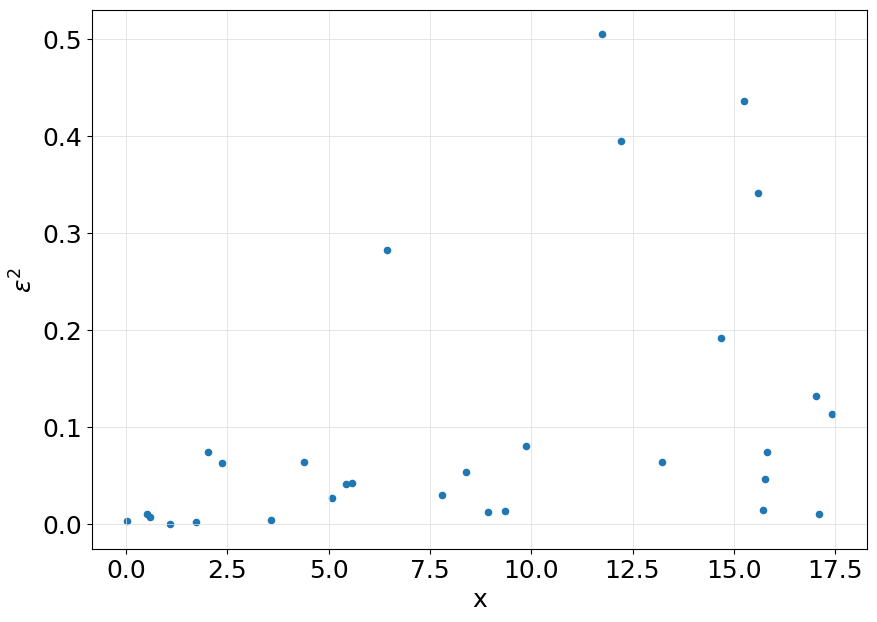

In [31]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.scatter(x, olsFit.resid**2, s=20)
ax.set_xlabel("x")
ax.set_ylabel(r"$\varepsilon^2$")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

This figures shows that we shouldn't have used OLS in the first place, the data is heteroscedastic: the residuals become larger for larger x-values.

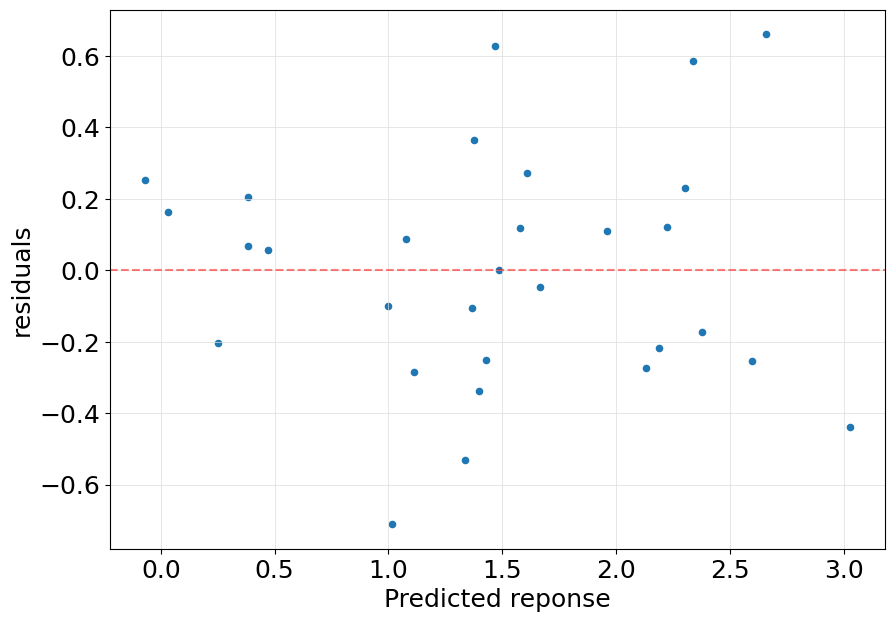

In [32]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.scatter(olsFit.fittedvalues, olsFit.resid, s=20)
ax.axhline(y = 0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel("Predicted reponse")
ax.set_ylabel("residuals")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### QQ-plot

QQ stands for Quantile-Quantile.

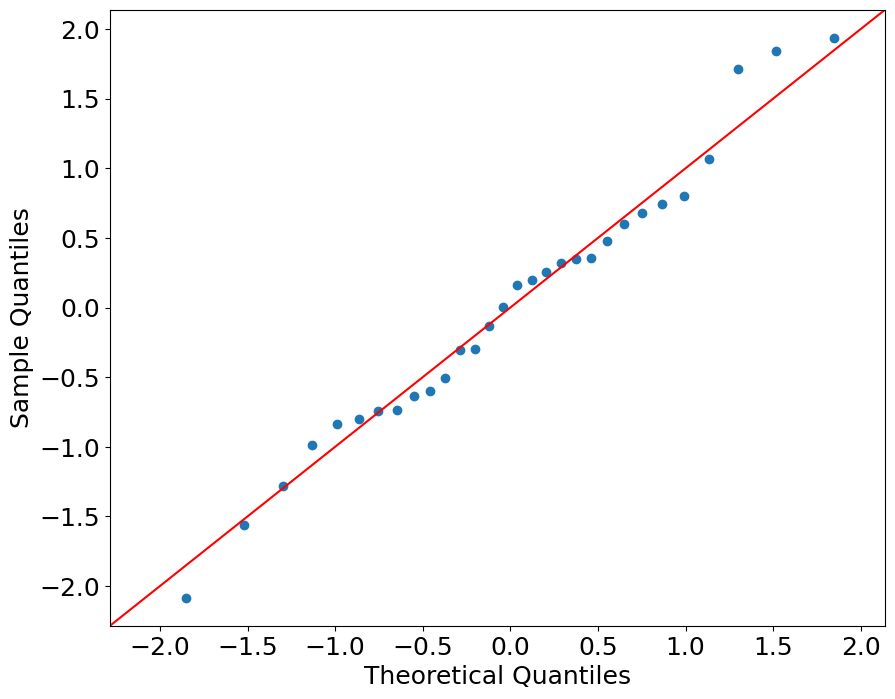

In [33]:
s2 = np.sum(olsFit.resid**2) / (N-K)
standardizedResiduals = olsFit.resid / np.sqrt(s2)
fig, ax = plt.subplots(1,1, figsize=(10,8))
qqplot(standardizedResiduals, line='45', ax=ax)
plt.show()

## Fitting the data with Weighted Least-Squares

In [34]:
sigma

array([0.10119736, 0.11531577, 0.11768282, 0.13266182, 0.15195908,
       0.16044778, 0.17130633, 0.20776455, 0.23216607, 0.25247273,
       0.26262211, 0.26717529, 0.29328856, 0.33409707, 0.35143825,
       0.36788602, 0.38075633, 0.39618998, 0.45237273, 0.46624428,
       0.4966598 , 0.54021389, 0.5573984 , 0.568144  , 0.57180873,
       0.57296607, 0.57477897, 0.61104969, 0.61329479, 0.62265669])

In [35]:
wlsFit = sm.WLS(y, X, weights=1/sigma**2).fit()

In [36]:
wlsFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.903
Model:                            WLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     125.2
Date:                Thu, 23 Mar 2023   Prob (F-statistic):           2.20e-14
Time:                        17:35:03   Log-Likelihood:                -3.8132
No. Observations:                  30   AIC:                             13.63
Df Residuals:                      27   BIC:                             17.83
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4634      0.057      8.120      0.000       0.346       0.580
x1             0.1109      0.010     10.988      0.000       0.090       0.132
x2             1.0101      0.069     14.596      0.000       0.868       1.152
==============================================================================
Omnibus:                        0.235   Durbin-Watson:                   2.488
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.417
Skew:                          -0.146   Prob(JB):                        0.812
Kurtosis:                       2.501   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plotting the mean response and a confidence interval

$$ \mathbf{y} = \mathbf{X} {\boldsymbol \theta} $$ 

In [37]:
covTheta = wlsFit.cov_params()
xvalues = np.linspace(0, 18, 200)
designX = sm.add_constant(np.column_stack([xvalues, np.sin(xvalues)]))
yvalues = designX @ wlsFit.params

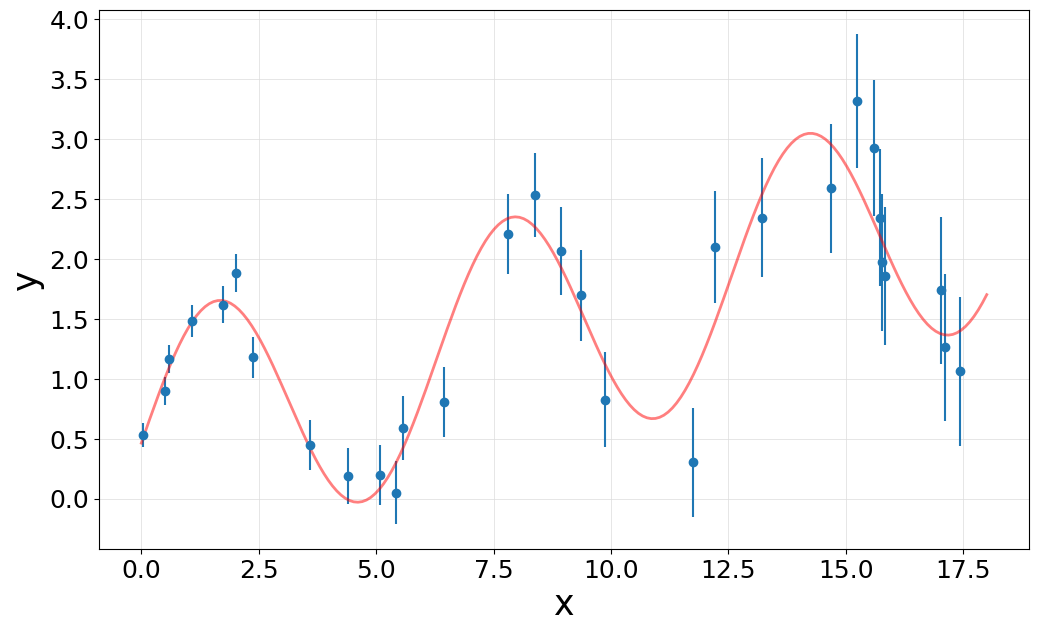

In [38]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.errorbar(x, y, yerr=sigma, fmt='o')
ax.plot(xvalues, yvalues, linewidth=2, c='red', alpha=0.5)
ax.set_xlabel('x', fontsize=25)
ax.set_ylabel('y', fontsize=25)
ax.set_facecolor('white')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

$$ \sigma_y^2 = \mathbf{x}' \; {\rm Cov}[\hat{\boldsymbol\theta}] \; \mathbf{x} $$

In [39]:
sigma_y = np.zeros_like(xvalues)
for n in range(len(xvalues)):
    xvec = [1, xvalues[n], np.sin(xvalues[n])]
    sigma_y[n] = np.sqrt(xvec @ covTheta @ xvec)

In [40]:
Tdistrib = sp.stats.t(N-K)
tMultiplier = Tdistrib.ppf(1-0.05/2)                 # 95% confidence interval

In [41]:
lowerCI = yvalues - tMultiplier * sigma_y            # CI stands for Confidence Interval
upperCI = yvalues + tMultiplier * sigma_y

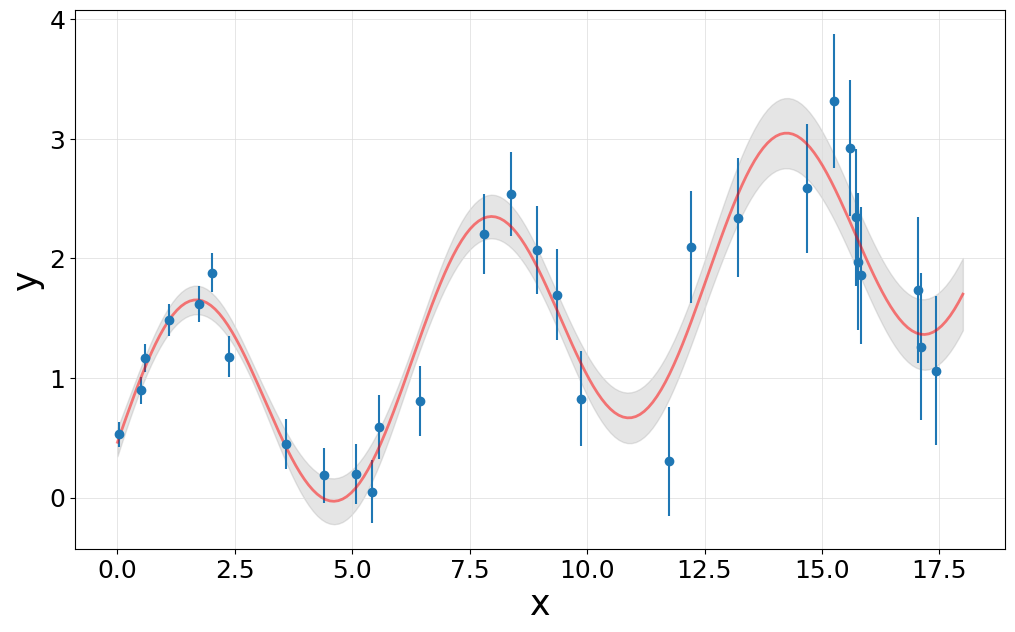

In [42]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.errorbar(x, y, yerr=sigma, fmt='o')
ax.plot(xvalues, yvalues, linewidth=2, c='red', alpha=0.5)
ax.fill_between(xvalues, lowerCI, upperCI, color='grey', alpha=0.2)
ax.set_xlabel('x', fontsize=25)
ax.set_ylabel('y', fontsize=25)
ax.set_facecolor('white')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()